# Assignment 3(due on 11/22)

## Student:梁纪元（12332296），Gtihub：Edc147258
## 批改人：吴昊天


## 得分：63/60

# ESE5023 Computing and Programming for Environmental Research
## Assignment 03 
--- 


In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from pathlib import Path
import calendar
%matplotlib inline

## 1.Niño 3.4 index  厄尔尼诺3.4指数

### 0 导入数据
导入下载好的数据"NOAA_NCDC_ERSST_v3b_SST.nc"，并使用netCDF4引擎读取文件。
将数据集赋值给变量'ds'，建立python下xarray数据集

In [2]:
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

### 1.1  
计算厄尔尼诺3.4区域海温的月气候学。
首先，计算厄尔尼诺3.4区域的平均海温。 
变量 sst_anom 为异常值，"group_data.mean(dim='time') "为气候学值。之后从海温时间序列中减去气候学，以获得异常。

In [3]:
group_data = ds.sst.groupby('time.month')
sst_anom = group_data - group_data.mean(dim='time')
ano=sst_anom.sel(lat=np.arange(-4,6,2)).sel(lon=np.arange(190,242,2)).mean(dim=['lat','lon'])

绘制厄尔尼诺3.4区域每月海温异常值

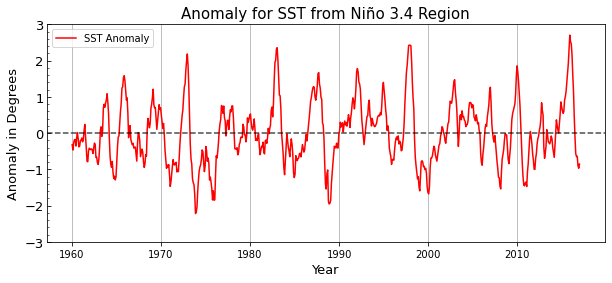

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))

# 创建图形对象
ax.plot(ano['time'], ano, color='r', label='SST Anomaly')

# 为图形图像创建网格
ax.grid(axis='x')
ax.tick_params(axis='y', labelsize=13, direction='in', length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.tick_params(axis="y", direction="in", which="minor", length=2)

# 创建坐标轴y和刻度线
ax.set_ylim(-3, 3)
ax.set_yticks(np.arange(-3, 3.2, 1))

# 在y=0处绘制基准线
ax.axhline(y=0, color='k', linestyle='dashed', alpha=0.7)

# 创建轴标签和标题
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Anomaly in Degrees', fontsize=13)
ax.set_title('Anomaly for SST from Niño 3.4 Region', fontsize=15)

# 添加图例
ax.legend()

plt.show()

### 1.2  
可视化计算出的Niño 3.4

In [5]:
# 定义经纬度范围
lat_range = slice(-4, 6, 2)
lon_range = slice(190, 242, 2)

# 计算滚动平均
ds_anom_rolling = sst_anom.rolling(time=3, center=True).mean()

# 选择特定经纬度范围并计算平均
g = ds_anom_rolling.sel(lat=lat_range, lon=lon_range).mean(dim=['lat', 'lon'])

# 转换为python下DataFrame
y = ano.to_dataframe()
y1 = g.to_dataframe()

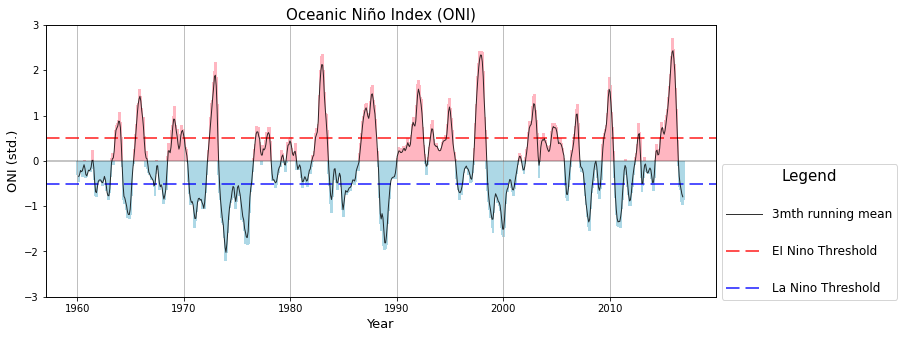

In [6]:
# 创建颜色列表
def color_mapping(value):
    return 'lightpink' if value >= 0 else 'lightblue'

# 创建图形和轴
fig, ax = plt.subplots(figsize=(12, 5))

# 绘制条形图
colors = [color_mapping(value) for value in y['sst']]
ax.bar(y.index, y['sst'], width=100, color=colors)

# 设置图形对象
ax.grid(axis='x')
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('ONI (std.)', fontsize=13)
ax.set_title('Oceanic Niño Index (ONI)', fontsize=15)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.set_ylim(-3, 3)
ax.set_yticks(np.arange(-3, 3.2, 1))

# 添加阈值线和图例
ax.axhline(y=0.5, color='r', linestyle=(0, (9, 4)), alpha=0.9, label='EI Nino Threshold')
ax.axhline(y=-0.5, color='b', linestyle=(0, (9, 4)), alpha=0.9, label='La Nino Threshold')


# 绘制条形图描边
ax2 = ax.twinx()
ax2.plot(y1.index, y1['sst'], color='k', label='3mth running mean', alpha=0.8, linewidth=1)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([])

# 设置 Legend
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
legend = ax2.legend(lines + lines2, labels + labels2, title='Legend',
                    handlelength=3, bbox_to_anchor=(1, 0.51), loc=2, borderaxespad=0.5, fontsize=12, labelspacing=2)
legend.set_title("Legend", prop={"size": 15})

plt.show()




从上图中，我们可以发现约 11 个 EI 事件和 8 个 La 事件。

### 1.1 从海温时间序列中减去气候学得到异常，绘制了温度统计图。
### 1.2 绘制了相近的图像。进行了分析。
### 得分：21/20

### =============================

## 2.Earth’s energy budget 地球的能量收支

读取数据集，存入'ds'中，便于进行数据处理与分析

In [7]:
ds = xr.open_dataset("CERES_EBAF-TOA_Edition4.1_200003-202203.nc", engine="netcdf4")
lon = ds.lon
lat = ds.lat

In [8]:
# 检查数据是否成功读取，打印各变量名称
print(ds.toa_lw_all_mon.long_name)
print(ds.toa_sw_all_mon.long_name)
print(ds.toa_net_all_mon.long_name)
print(ds.solar_mon.long_name)

Top of The Atmosphere Longwave Flux, All-Sky conditions, Monthly Means
Top of The Atmosphere Shortwave Flux, All-Sky conditions, Monthly Means
Top of The Atmosphere Net Flux, All-Sky conditions, Monthly Means
Incoming Solar Flux, Monthly Means


### 2.1  
分析并绘制全天条件下的时间平均TOA长波、短波和太阳辐射的2D图。

**加法 TOA 净通量 = 太阳辐射 - TOA 长波 - TOA 短波。**
将 TOA 净通量数据与加法 TOA 净通量进行比较。



In [9]:
toa_lw_all_mon = ds.toa_lw_all_mon.mean(dim='time')
toa_sw_all_mon = ds.toa_sw_all_mon.mean(dim='time')
solar_mon = ds.solar_mon.mean(dim='time')
toa_net_all_mon = ds.toa_net_all_mon.mean(dim='time')

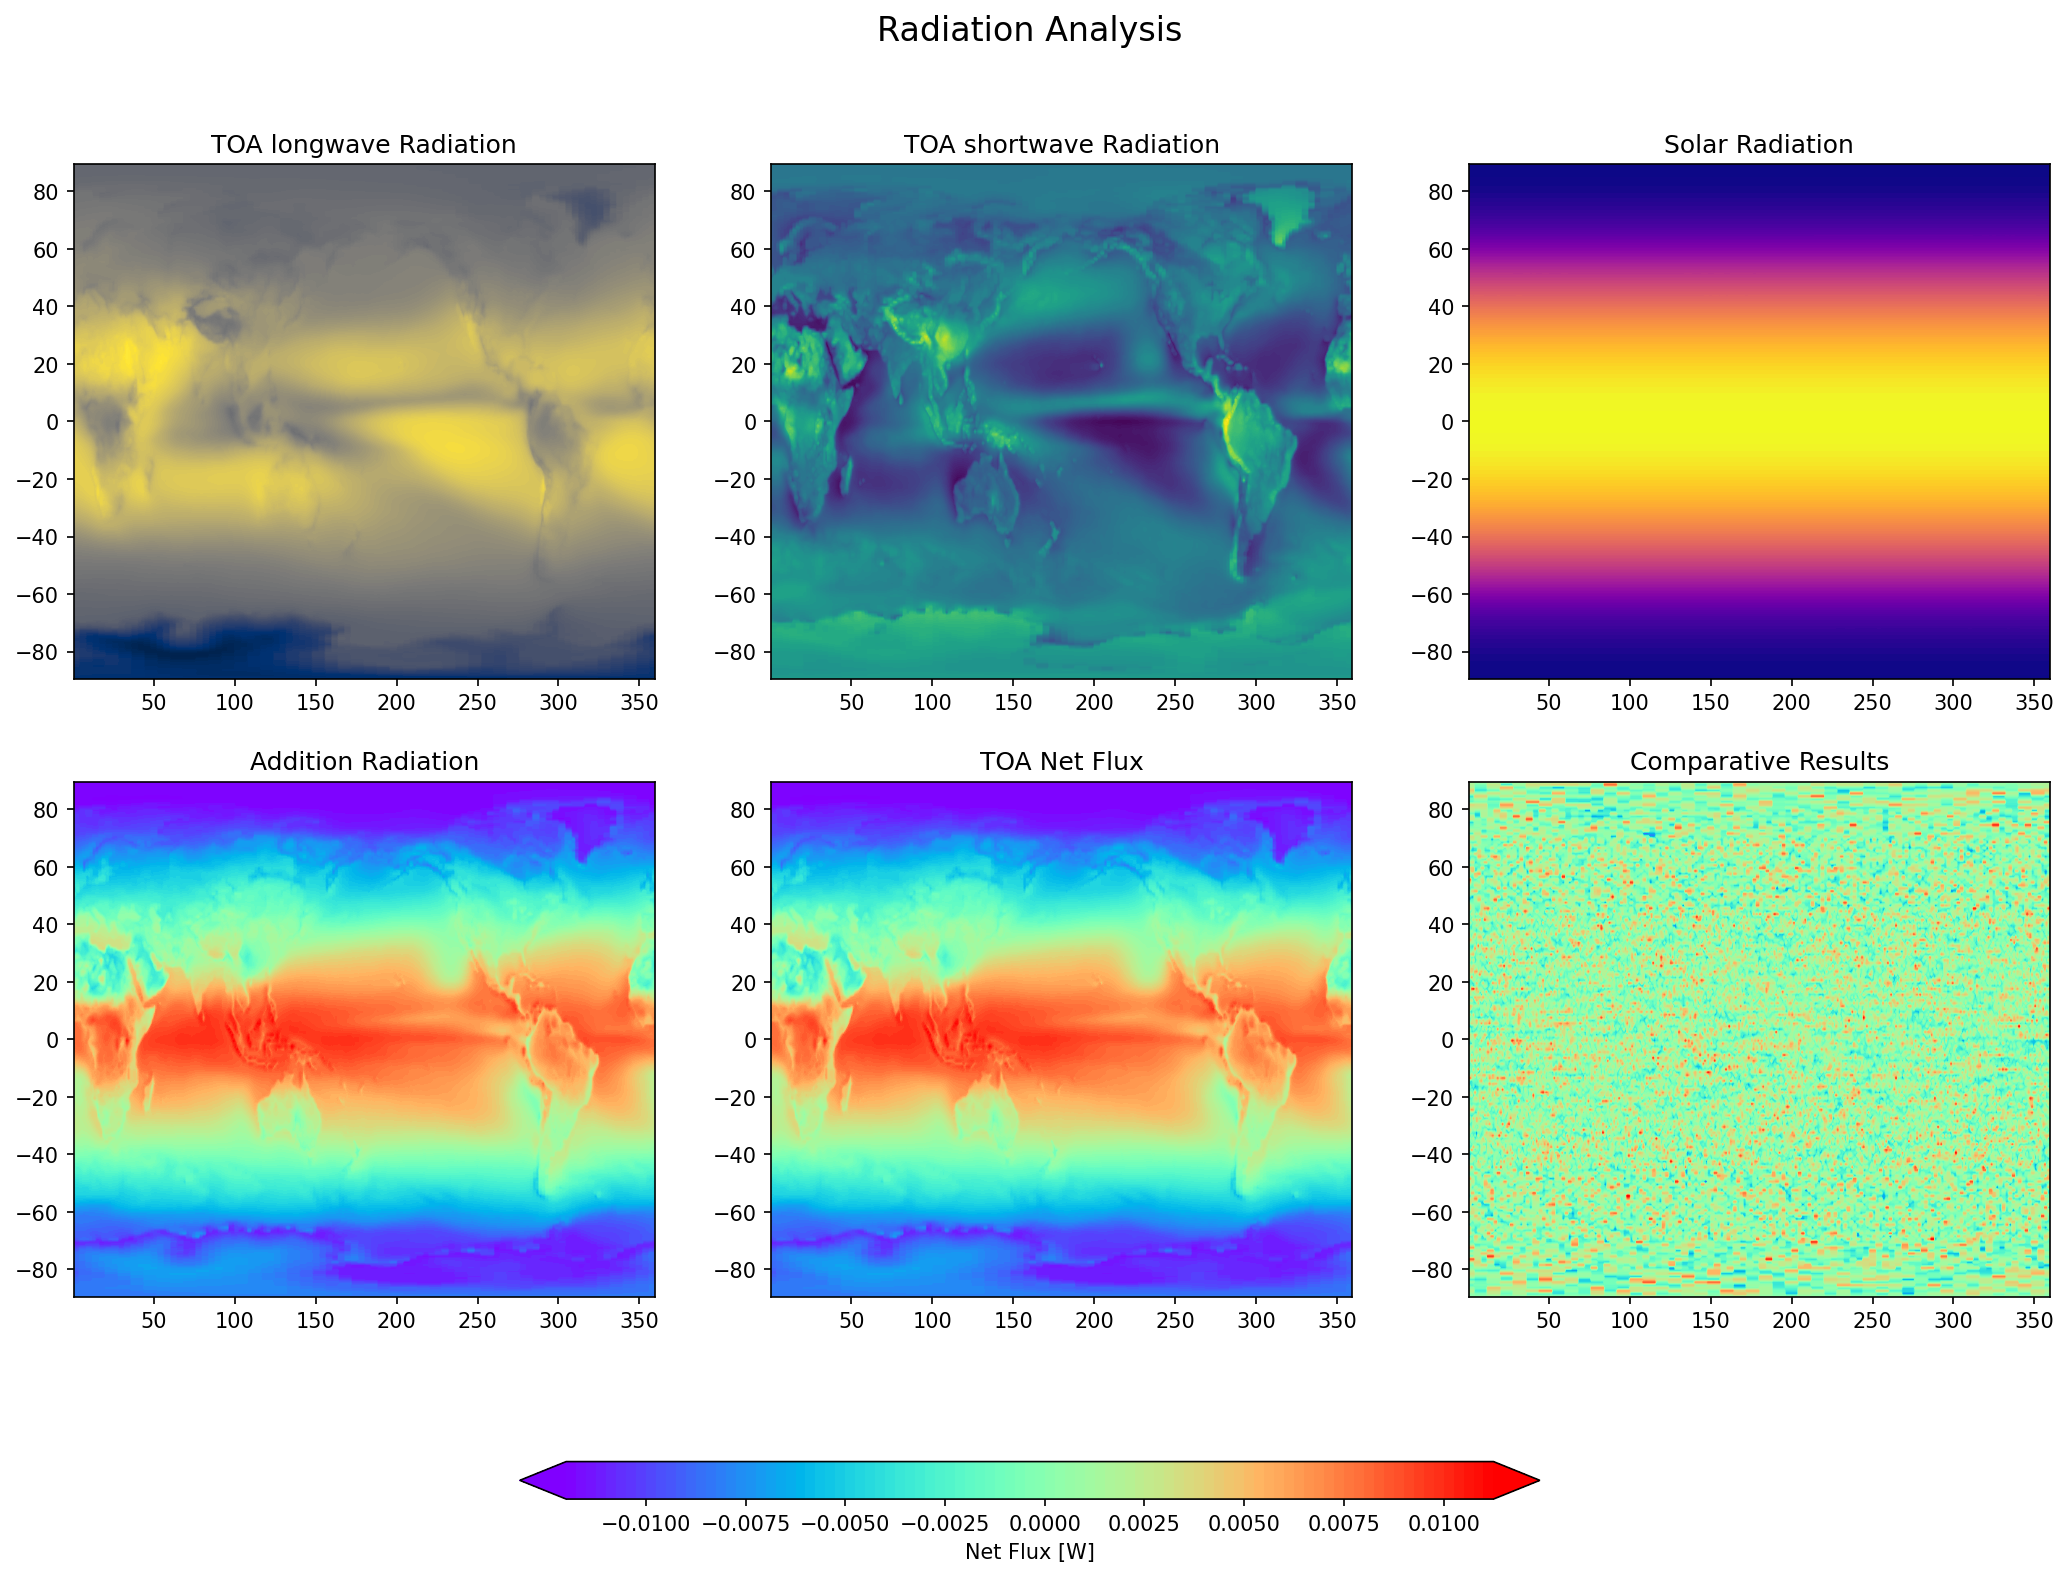

In [10]:
# 创建图形和轴
fig, axes = plt.subplots(2, 3, figsize=(17, 10), dpi=150)

# 画板基本设置
titles = ["TOA longwave Radiation", "TOA shortwave Radiation", "Solar Radiation", "Addition Radiation", "TOA Net Flux", "Comparative Results"]
data = [toa_lw_all_mon, toa_sw_all_mon, solar_mon, solar_mon - toa_sw_all_mon - toa_lw_all_mon, toa_net_all_mon, solar_mon - toa_sw_all_mon - toa_lw_all_mon - toa_net_all_mon]
cmaps = ['cividis', 'viridis', 'plasma', 'rainbow', 'rainbow','rainbow']

# 循环绘制6个子图
for ax, title, data, cmap in zip(axes.flatten(), titles, data, cmaps):
    im = ax.contourf(lon, lat, data, cmap=cmap, levels=100, extend='both')
    ax.set_title(title, fontdict={'fontsize': 12})

# 绘制色条图例
cax = fig.add_axes([0.3, -0.01, 0.4, 0.025])
fig.colorbar(im, cax=cax, orientation='horizontal', extend='both').set_label('Net Flux [W]')

plt.suptitle("Radiation Analysis", fontsize=16)
plt.show()

直观验证添加量是否等同于 TOA 净通量.子图6为子图4和子图5数据相减  

### 2.2
计算并验证TOA入射太阳波、出射长波和出射短波大致与上图相符。

使用`weights = np.cos(np.deg2rad(ds.lat))`获得不同纬度的面积权重。
给定数据的单位是[W/m²]，表示单位面积的通量

In [11]:
weights = np.cos(np.deg2rad(ds.lat))

# 对数据集进行权重平均，创建权重数组
toa_lw_all_mon_gr = ds.toa_lw_all_mon.weighted(weights).mean(dim=['time','lon','lat'])
toa_sw_all_mon_gr = ds.toa_sw_all_mon.weighted(weights).mean(dim=['time','lon','lat'])
solar_mon_gr = ds.solar_mon.weighted(weights).mean(dim=['time','lon','lat'])

# 打印输出各个全球平均的辐射分量的数值
print("outgoing longwave:",toa_lw_all_mon_gr.values,'W·m^-2')
print("outgoing shortwave:",toa_sw_all_mon_gr.values,'W·m^-2')
print("TOA incoming solar:",solar_mon_gr.values,'W·m^-2')

outgoing longwave: 240.33322 W·m^-2
outgoing shortwave: 98.93702 W·m^-2
TOA incoming solar: 340.3247 W·m^-2


outgoing longwave: 240.26692 W·m^-2  
outgoing shortwave: 99.13806 W·m^-2  
TOA incoming solar: 340.28326 W·m^-2  
**验证 TOA 太阳辐射入射角、长波出射角和短波出射角是否与给定的漫画大致吻合**

### 2.3  
使用 `ds.toa_net_all_mon.mean(dim='lon')`计算每个1度纬度带的净辐射总量，并使用`dataset.plot.contourf`进行绘图

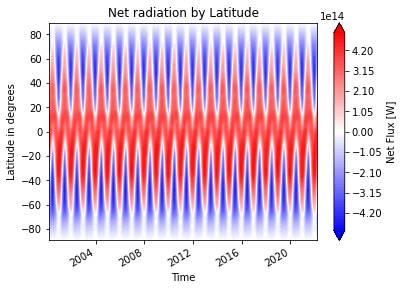

In [12]:
# 'ds'是包含平均辐射的xarray数据，计算净辐射总量
p = ds.toa_net_all_mon.weighted(weights).sum(dim='lon') * 111000**2

# 绘图
p.plot.contourf(x='time', levels=100, cmap='bwr',extend = 'both').colorbar.set_label('Net Flux [W]')
plt.ylabel('Latitude in degrees')
plt.xlabel('Time')
plt.title('Net radiation by Latitude')
plt.show()

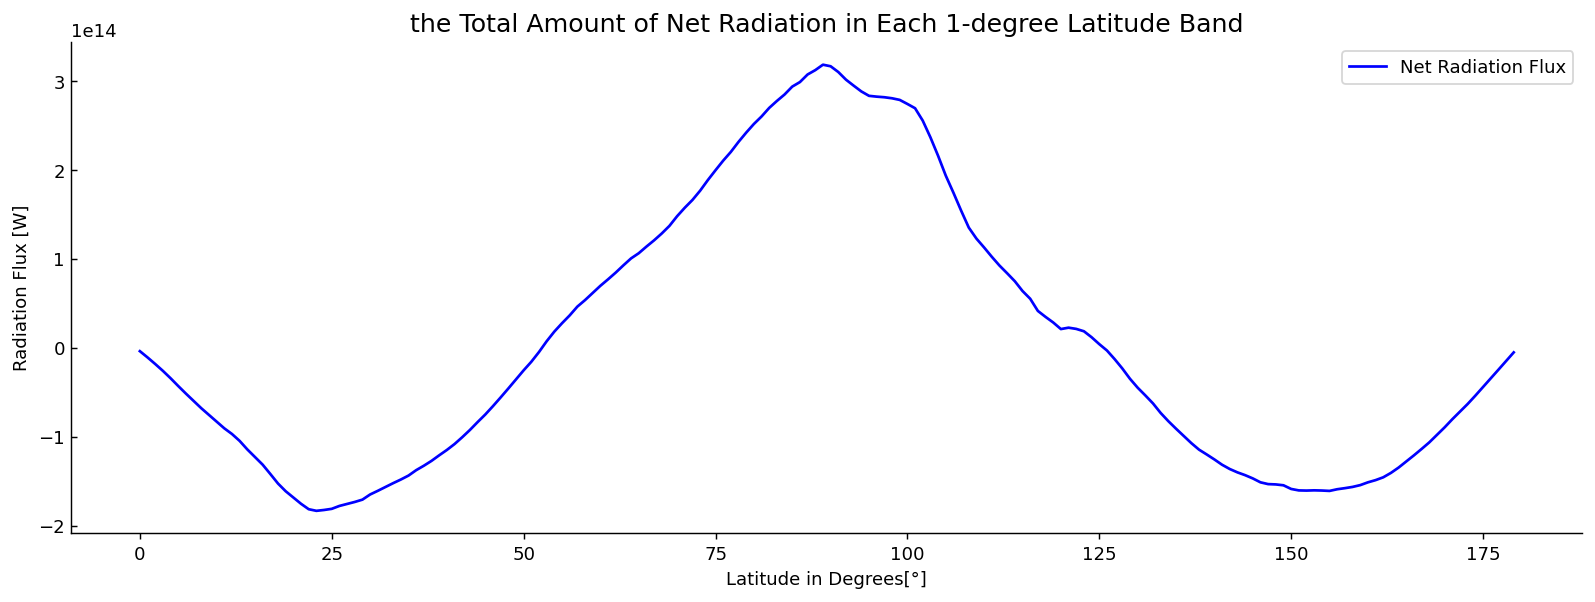

In [13]:
# 计算大气顶部净辐射的地带平均值，应用空间权重，计算一段时间内的纬度平均值。
pt = ds.toa_net_all_mon.weighted(weights).sum(dim='lon').mean(dim='time') * 111000**2

# 创建图形和轴
fig, ax= plt.subplots(figsize=(15,5),dpi=130)

# 绘制曲线
ax.plot(pt,label='Net Radiation Flux',linestyle='-',color='b')

# 设置图表属性
ax.set_xlabel('Latitude in Degrees[°]')
ax.set_ylabel('Radiation Flux [W]')
ax.set_title('the Total Amount of Net Radiation in Each 1-degree Latitude Band',fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置刻度线方向
ax.tick_params(axis='y', direction='in')

# 添加图例
ax.legend(loc='best')
plt.show()

### 2.4  
计算和绘制低云区和高云区的时间平均外发短波和长波辐射的合成图。

*定义低云区为 ≤25% ，高云区为 ≥75%*

In [14]:
# 加载经纬度数据
lon = ds.lon
lat = ds.lat

# 根据云覆盖率划分低云和高云条件，云覆盖率低于等于25%为低云，大于等于75%为高云
low = ds.cldarea_total_daynight_mon.mean(dim='time') <= 25
high = ds.cldarea_total_daynight_mon.mean(dim='time')  >= 75

# 计算低云和高云条件下的全球平均短波辐射
sw_low = ds.toa_sw_all_mon.where(low).mean(dim='time')
sw_high = ds.toa_sw_all_mon.where(high).mean(dim='time')

# 计算低云和高云条件下的全球平均长波辐射
lw_low = ds.toa_lw_all_mon.where(low).mean(dim='time')
lw_high = ds.toa_lw_all_mon.where(high).mean(dim='time')

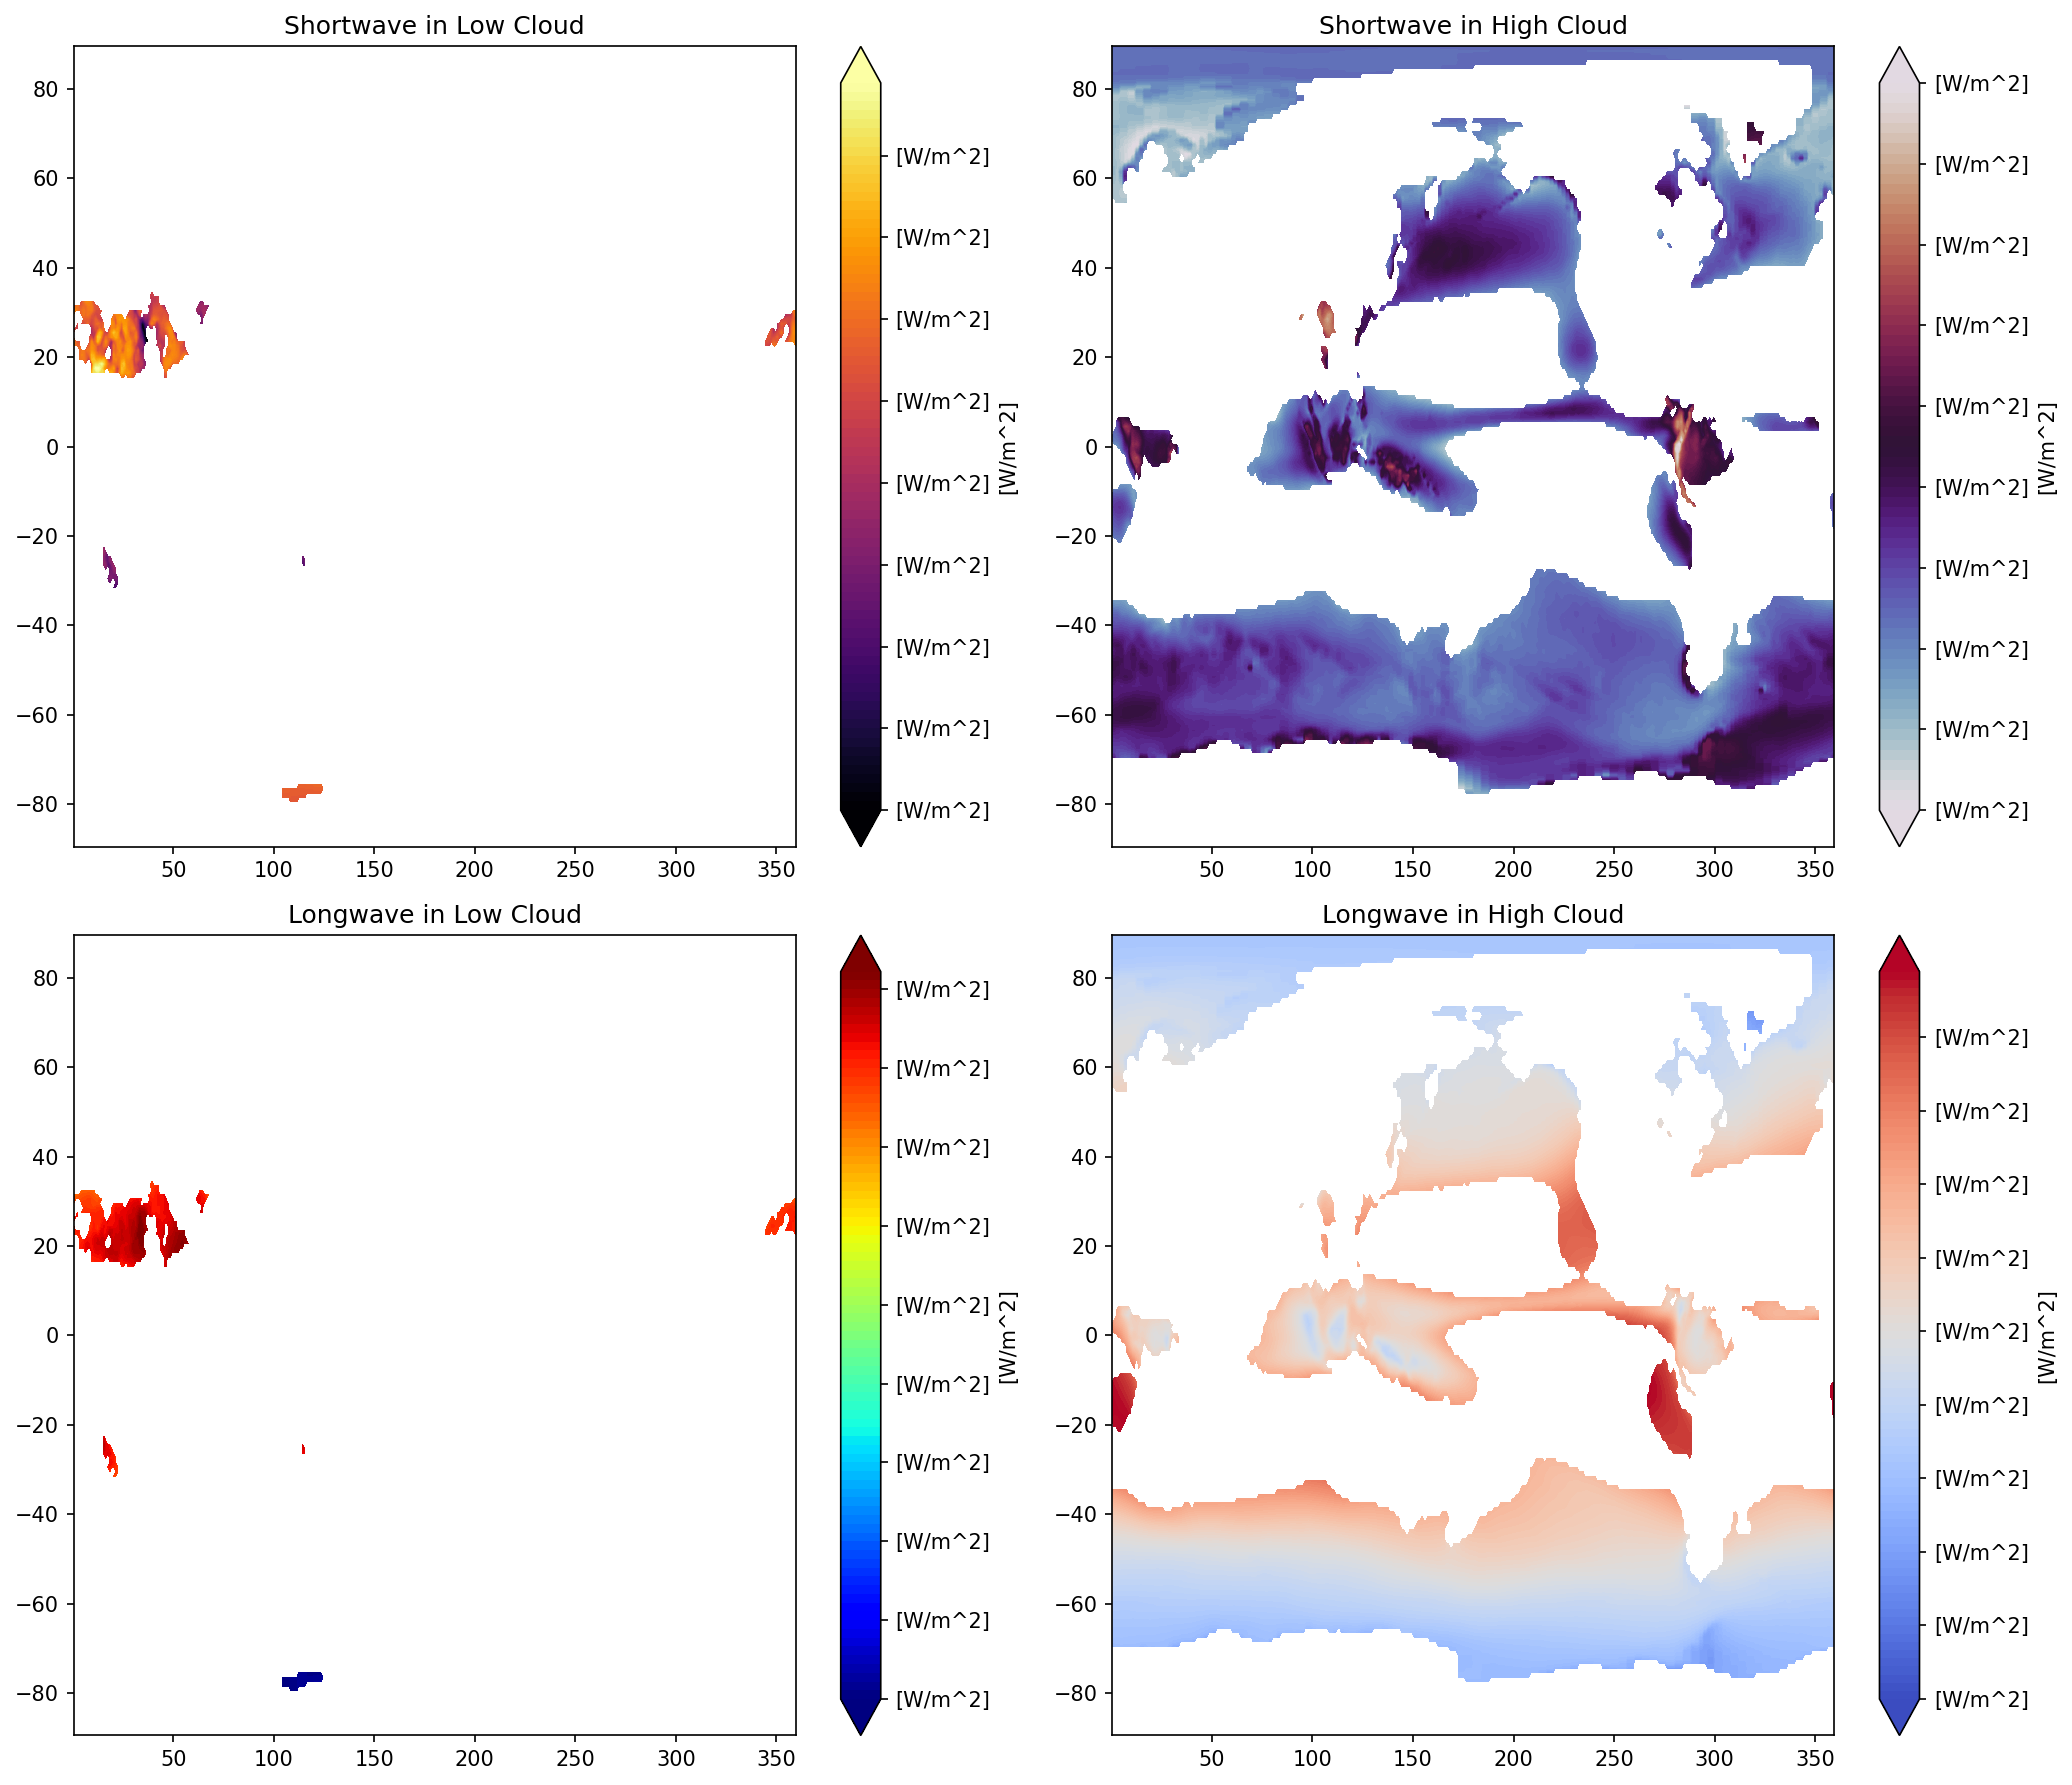

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=150)
fig.subplots_adjust(hspace=0.4)  # 调整子图之间的垂直间距

# 绘制子图
contourf_params = {'levels': 100, 'extend': 'both'}
im1 = axes[0, 0].contourf(lon, lat, sw_low, cmap='inferno', **contourf_params)
axes[0, 0].set_title("Shortwave in Low Cloud")

im2 = axes[0, 1].contourf(lon, lat, sw_high, cmap='twilight', **contourf_params)
axes[0, 1].set_title("Shortwave in High Cloud")

im3 = axes[1, 0].contourf(lon, lat, lw_low, cmap='jet', **contourf_params)
axes[1, 0].set_title("Longwave in Low Cloud")

im4 = axes[1, 1].contourf(lon, lat, lw_high, cmap='coolwarm', **contourf_params)
axes[1, 1].set_title("Longwave in High Cloud")

# 统一色条
cbar_params = {'format': '[W/m^2]'}
for ax, im in zip(axes.flatten(), [im1, im2, im3, im4]):
    cbar = fig.colorbar(im, ax=ax, **cbar_params)
    cbar.set_label('[W/m^2]')

plt.tight_layout()
plt.show()

### 2.5  
计算高低云区合成的短波和长波辐射的全球平均值

In [16]:
# 根据低云高和高云高的条件创建掩码，然后与权重相乘，按照时间、月份、经度和纬度进行分组和平均，最终得到全球月平均的长波辐射。
weights = np.cos(np.deg2rad(ds.lat))
sw_low_gm = ds.toa_sw_all_mon.where(low).weighted(weights).mean(dim=['lon','lat'])
sw_high_gm = ds.toa_sw_all_mon.where(high).weighted(weights).mean(dim=['lon','lat'])
lw_low_gm = ds.toa_lw_all_mon.where(low).weighted(weights).mean(dim=['lon','lat'])
lw_high_gm = ds.toa_lw_all_mon.where(high).weighted(weights).mean(dim=['lon','lat'])

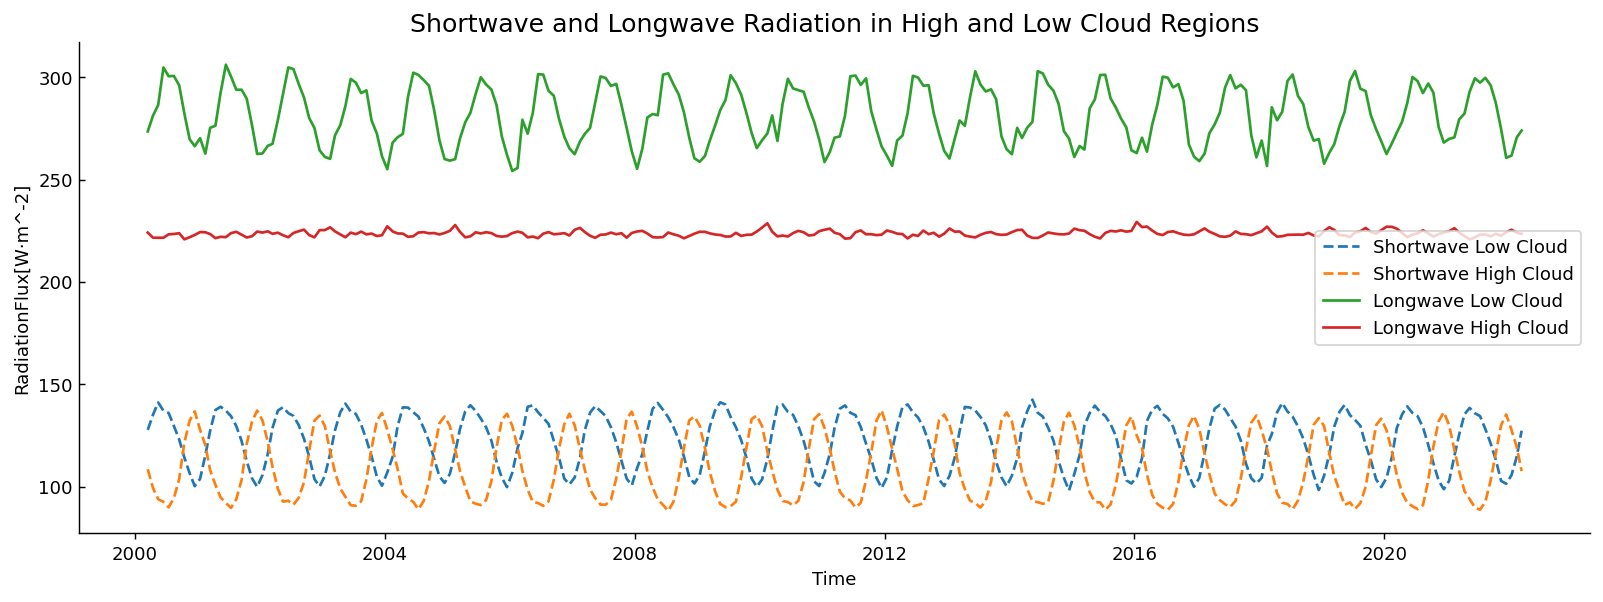

In [17]:
# 创建时间序列
time = lw_high_gm.time

# 创建图形和轴
fig, ax= plt.subplots(figsize=(15,5),dpi=130)

# 绘图
ax.plot(time,sw_low_gm,label='Shortwave Low Cloud',linestyle='--')
ax.plot(time,sw_high_gm,label='Shortwave High Cloud',linestyle='--')
ax.plot(time,lw_low_gm,label='Longwave Low Cloud')
ax.plot(time,lw_high_gm,label='Longwave High Cloud')

# 设置图表属性
ax.set_xlabel('Time')
ax.set_ylabel('RadiationFlux[W·m^-2]')
ax.set_title('Shortwave and Longwave Radiation in High and Low Cloud Regions',fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置刻度线
ax.tick_params(axis='y', direction='in')

# 添加图例
ax.legend(loc='best')

plt.show()

In [18]:
sw_low_gm_t = ds.toa_sw_all_mon.where(low).weighted(weights).mean(dim=['lon','lat','time'])
sw_high_gm_t = ds.toa_sw_all_mon.where(high).weighted(weights).mean(dim=['lon','lat','time'])
lw_low_gm_t = ds.toa_lw_all_mon.where(low).weighted(weights).mean(dim=['lon','lat','time'])
lw_high_gm_t = ds.toa_lw_all_mon.where(high).weighted(weights).mean(dim=['lon','lat','time'])
print('Shortwave in Low Cloud:',sw_low_gm_t.values,'W·m^-2\n',
      'Shortwave in High Cloud:',sw_high_gm_t.values,'W·m^-2\n',
      'Longwave in low Cloud:',lw_low_gm_t.values,'W·m^-2\n',
      'longwave in High Cloud:',lw_high_gm_t.values,'W·m^-2')

Shortwave in Low Cloud: 122.24167 W·m^-2
 Shortwave in High Cloud: 109.03611 W·m^-2
 Longwave in low Cloud: 281.17838 W·m^-2
 longwave in High Cloud: 223.74202 W·m^-2


What is the overall effect of clouds on shortwave and longwave radiation?  
云对短波和长波辐射的总体影响是什么？

对长波来说，云层会减少长波向外辐射的量。对短波来说，高云和低云的影响正好相反，高云区辐射的短波多，低云区辐射的短波少。在春季和冬季，低云区的短波辐射较多，而高云区的短波辐射较少。


### 2.1 从绘制图像正确，验证了辐射平衡。
### 2.2 计算正确，能量守恒。
### 2.3 图像绘制正确。
### 2.4 图像绘制正确。
### 2.5 计算正确。进行了分析
### 得分：31/30

### =============================

# 3.Explore a netCDF dataset

美国国家航空航天局戈达德地球科学数据和信息服务中心（GES DISC）网站上下载netCDF格式的数据集，本节选取了GLDAS-CLSM数据集（GLDAS_NOAH10_3H 2.1），下载了64份数据。

In [19]:
filepath = Path('E:\CodeField\My_JupyterNotebook\PS3data\da')
filelist = list(filepath.glob('*.nc4'))

In [20]:
filepath = 'E:\CodeField\My_JupyterNotebook\PS3data\da'
filelist = list(Path(filepath).glob('*.nc4'))
ds = xr.open_mfdataset(filelist)
ds

<xarray.Dataset>
Dimensions:                (time: 64, bnds: 2, lon: 360, lat: 150)
Coordinates:
  * time                   (time) datetime64[ns] 2019-01-01 ... 2019-01-08T21...
  * lon                    (lon) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                    (lat) float32 -59.5 -58.5 -57.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Swnet_tavg             (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Lwnet_tavg             (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qle_tavg               (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qh_tavg                (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qg_tavg                (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Tair_f_inst            (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qair_f_inst            (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Psurf_f_inst           (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    SWdown_f_tavg          (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    LWdown_f_tavg          (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2020-01-20T11:45:11.145
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

### 3.1

绘制ds.Qsb_acc的时间序列

In [21]:
dq_gro = ds.Qsb_acc.groupby('time.month')
dq_average = dq_gro - dq_gro.mean(dim='time')
dq_reav = dq_average.mean(dim=['lat','lon'])
dq_reav


<xarray.DataArray 'Qsb_acc' (time: 64)>
dask.array<mean_agg-aggregate, shape=(64,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2019-01-08T21:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

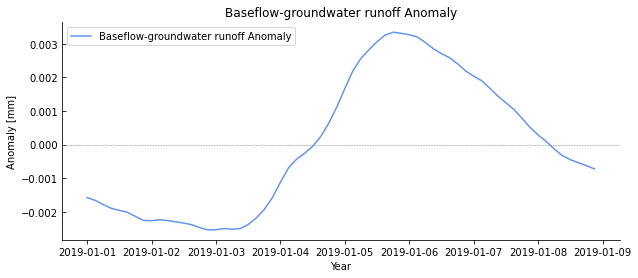

In [22]:
g = dq_reav.copy()
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(g['time'],g,color='cornflowerblue',label='Baseflow-groundwater runoff Anomaly')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly [mm]')
ax.set_title('Baseflow-groundwater runoff Anomaly')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', direction='in')
plt.legend()
plt.show()

### 3.2  
使用数据集制作至少 5 个不同的图

**图1**  Qsb_acc数据的核密度估计

In [23]:
y = ds.Qsb_acc.mean(dim=['lon','lat']).to_dataframe()
y['month'] = y['month'] = y.index.month

Text(0.5, 0.98, 'KDE Daily Baseflow-groundwater runoff')

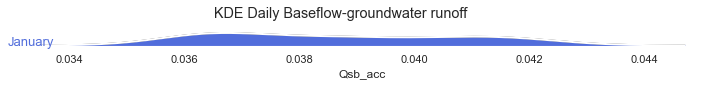

In [24]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette('coolwarm', 12)
g = sns.FacetGrid(y, palette=palette, row="month", hue="month", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Qsb_acc", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="Qsb_acc", color='black')
g.map(sns.kdeplot, 'Qsb_acc', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)
def label(x, color, label):
    ax = plt.gca()
    month_name = calendar.month_name[int(label)]
    ax.text(0, .2, month_name, color=color, fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "month")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Qsb_acc",ylabel='')
plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
g.despine(bottom=True,left=True)
g.fig.suptitle('KDE Daily Baseflow-groundwater runoff', y=0.98)

核密度估计 (KDE) 图用于显示每天的 "Qsb_acc "值的分布情况。 KDE 图显示 Y 轴上变量的概率密度。 

**图 2**   10 厘米深度的土壤温度（°C）与土壤湿度（毫米）的相关性分析

In [25]:
sns.set(color_codes=True)

In [26]:
cords = ds[['Snowf_tavg',   #Snow precipitation rate       
            'Rainf_f_tavg', #Total precipitation rate           
            'Evap_tavg',    #Evapotranspiration
            'SoilTMP0_10cm_inst', #Soil temperature
            'SoilMoi0_10cm_inst',   #Surface Soil moisture
            'Tveg_tavg'      #Transpiration
            ]]
cords_df = cords.to_dataframe()


In [27]:
cords_df = cords_df.dropna()
cords_df = cords_df.groupby('time').mean()

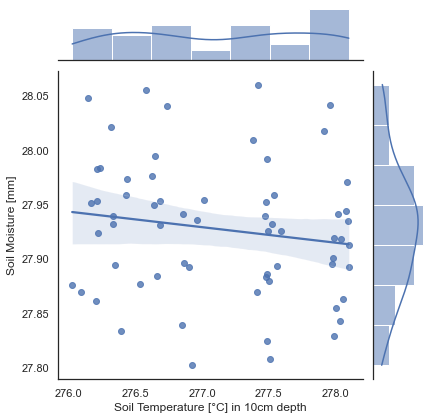

In [28]:
sns.set(style='white',palette='deep',color_codes=True)
sns.jointplot(x='SoilTMP0_10cm_inst', y='SoilMoi0_10cm_inst', data=cords_df, kind='reg')
plt.xlabel('Soil Temperature [°C] in 10cm depth')
plt.ylabel('Soil Moisture [mm]')
plt.show()

**图 3** 6变量相关性分析
*Snowf_tavg* : **降雪率**       
*Rainf_f_tavg* : **总降水率**               
*Evap_tavg* : **蒸散量**  
*SoilTMP0_10cm_inst* : **地表土壤温度**  
*SoilMoist_10cm_inst* : **地表土壤湿度**  
*TVeg_tavg* : **蒸发量**  


In [29]:
new_column_names = {'Snowf_tavg': 'SnowPrecipitated rate', 'Rainf_f_tavg': 'Total precipitation rate', 'Evap_tavg': 'Evapotranspiration', 'SoilTMP0_10cm_inst': 'Soil temperature', 'SoilMoist_10cm_inst': 'Surface Soil moistur', 'TVeg_tavg': 'Transpiration'}

# 使用rename()函数更改列名
cords_df = cords_df.rename(columns=new_column_names)

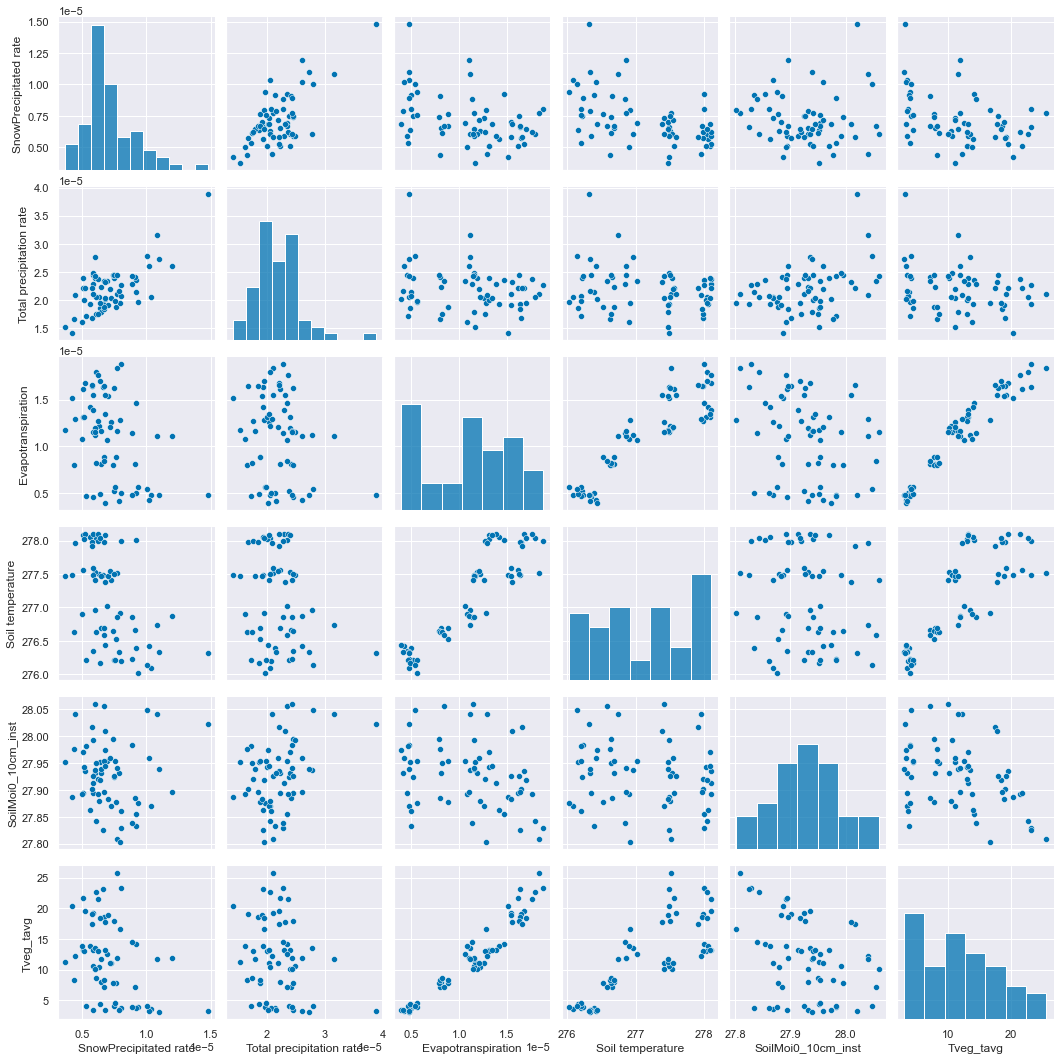

In [30]:
sns.set(style='darkgrid',palette='colorblind',color_codes=True)
sns.pairplot(cords_df)

We can observe the relationship between the variables.  

**图 4**  变量的时间序列分解   

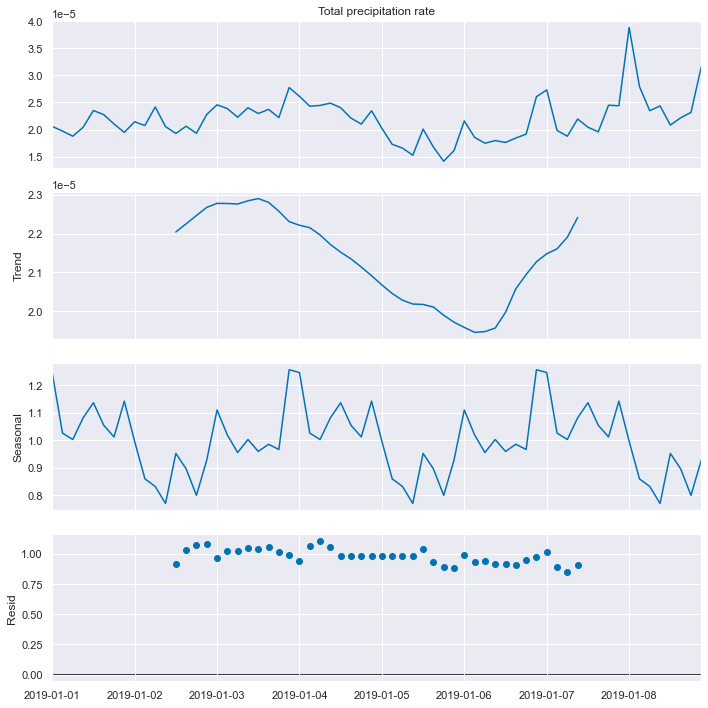

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# 导入数据
df2 = cords_df['Total precipitation rate'].copy()

# 序列分解 
result = seasonal_decompose(df2, model='multiplicative')

# 绘图
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('')
plt.show()

**图 5**   Qsb_acc数据绘制柱状图

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


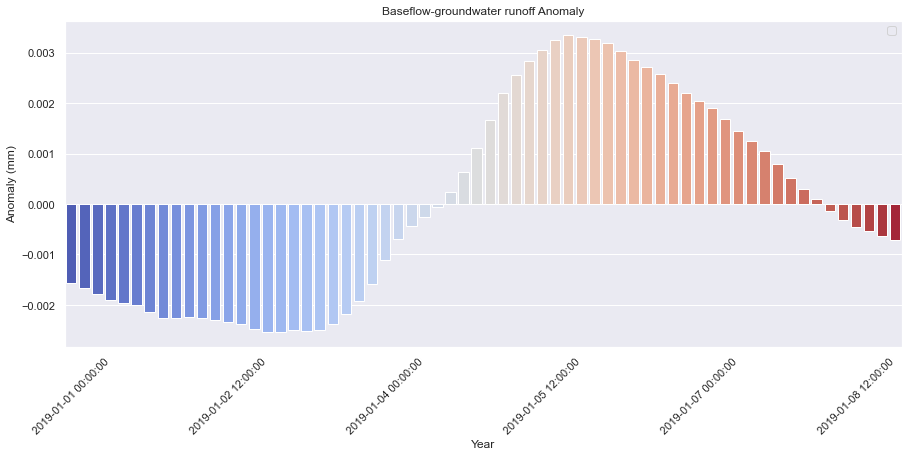

In [33]:
import seaborn as sns
gs = dq_reav.copy().to_dataframe()
gs["date"] = gs.index
plt.figure(figsize=(15, 6))
sns.barplot(x='date',y='Qsb_acc',data=gs,palette = "coolwarm")
plt.xticks(ticks = np.arange(0, 64, 12),rotation=45)
plt.xlabel('Year')
plt.ylabel('Anomaly (mm)')
plt.title('Baseflow-groundwater runoff Anomaly')
plt.legend()
plt.show()

### 3.1 满足题目要求。
### 3.2 满足题目要求。
### 得分：11/10

### =============================